In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2_3 import * 

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

In [ ]:
cf

array([[ 784.57624268,  -93.61405064, -156.63581845,    2.28225017,
           0.95225006,    1.95350003],
       [ 779.80309936,  -93.0955292 , -155.6282712 ,    1.36549997,
           1.45650005,    2.59900022],
       [ 875.98538323, -105.72439904, -174.73795757,    0.83375001,
           1.77175009,    0.73750007],
       ...,
       [ 741.20094106,  -88.34534765, -147.99184888,    2.56474996,
           1.57500005,    2.47574997],
       [ 757.66172186,  -90.34700559, -151.26807672,    1.61825013,
           1.92200017,    2.49900007],
       [ 803.44132066,  -96.45390954, -160.33241851,    0.79150009,
           2.24175   ,    2.16525006]])

In [ ]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:03<00:00, 13.14it/s]

30192


In [ ]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [ ]:
g = get_graph(cf,1,n_neigh,"cry")

In [ ]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [ ]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 20
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [ ]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:01<00:00, 22479.48it/s]


In [ ]:
graphs = graphs_device
total_graphs = len(graphs)


In [ ]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [ ]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [ ]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [ ]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [ ]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 3453.0615
	Test: 	MSE Loss: 3354.0631
Epoch: 002
	Train:	MSE Loss: 2784.8848
	Test: 	MSE Loss: 2742.3558
Epoch: 003
	Train:	MSE Loss: 2215.2730
	Test: 	MSE Loss: 2077.4288
Epoch: 004
	Train:	MSE Loss: 1816.6383
	Test: 	MSE Loss: 1489.7967
Epoch: 005
	Train:	MSE Loss: 1382.8152
	Test: 	MSE Loss: 1179.6922
Epoch: 006
	Train:	MSE Loss: 1172.2717
	Test: 	MSE Loss: 1107.9831
Epoch: 007
	Train:	MSE Loss: 1085.1511
	Test: 	MSE Loss: 1044.5200
Epoch: 008
	Train:	MSE Loss: 1022.5128
	Test: 	MSE Loss: 994.1131
Epoch: 009
	Train:	MSE Loss: 971.2477
	Test: 	MSE Loss: 973.1587
Epoch: 010
	Train:	MSE Loss: 929.4123
	Test: 	MSE Loss: 908.6037
Epoch: 011
	Train:	MSE Loss: 894.0037
	Test: 	MSE Loss: 888.7284
Epoch: 012
	Train:	MSE Loss: 867.8057
	Test: 	MSE Loss: 861.8816
Epoch: 013
	Train:	MSE Loss: 849.7584
	Test: 	MSE Loss: 846.0834
Epoch: 014
	Train:	MSE Loss: 831.4808
	Test: 	MSE Loss: 828.0158
Epoch: 015
	Train:	MSE Loss: 814.8195
	Test: 	MSE Loss: 810.9415
Epoch: 016

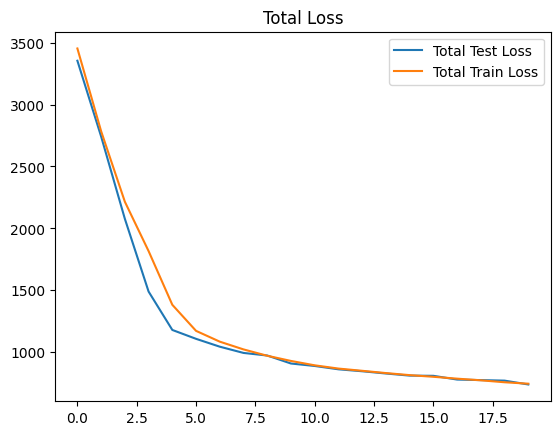

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

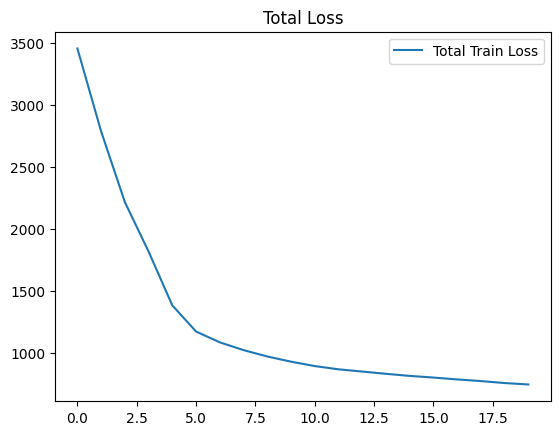

In [ ]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

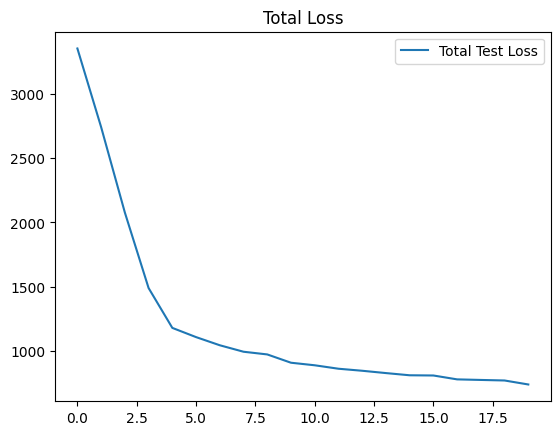

In [ ]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [ ]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 647.7184465977009


In [ ]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [ ]:
decoded_feature[0][heavy_indices]

tensor([[-4.1933e-01, -1.3259e-02, -3.5258e-02,  1.5661e+01,  1.7733e+01,
          1.6249e+01],
        [-3.8822e-01, -1.0015e+00, -1.2780e+00,  1.6603e+01,  1.6801e+01,
          1.6888e+01],
        [-3.6577e-01, -1.2286e+00, -1.5522e+00,  1.6249e+01,  1.6398e+01,
          1.6506e+01],
        [-4.1082e-01, -7.8394e-01, -1.0122e+00,  1.6905e+01,  1.7153e+01,
          1.7193e+01],
        [-3.6211e-01, -1.2662e+00, -1.5975e+00,  1.6185e+01,  1.6348e+01,
          1.6447e+01],
        [-4.0306e-01, -8.5806e-01, -1.1031e+00,  1.6803e+01,  1.7044e+01,
          1.7092e+01],
        [-3.3077e-01, -1.5904e+00, -1.9857e+00,  1.5701e+01,  1.5991e+01,
          1.5904e+01],
        [-3.7438e-01, -1.1411e+00, -1.4469e+00,  1.6377e+01,  1.6543e+01,
          1.6652e+01],
        [-3.8634e-01, -1.0201e+00, -1.3005e+00,  1.6576e+01,  1.6768e+01,
          1.6856e+01],
        [-3.4054e-01, -1.4900e+00, -1.8657e+00,  1.5832e+01,  1.6081e+01,
          1.6071e+01],
        [-3.6456e-01, -1.2408e

In [ ]:
input_feature[0][heavy_indices]

tensor([[-7.3465,  0.1674, -0.2792, 20.3900, 23.4300, 10.5100],
        [-6.9056,  0.2154, -0.2777, 18.5950, 22.2825, 12.2550],
        [-8.1435,  0.0743, -0.2828, 23.0825, 23.3225,  9.8400],
        [-6.5277,  0.2574, -0.2830, 19.4625, 23.8900,  7.7375],
        [-5.9971,  0.3145, -0.2897, 20.3225, 21.2275,  7.9950],
        [-7.0025,  0.2073, -0.2737, 17.2350, 24.5950, 11.4875],
        [-6.9273,  0.2152, -0.2755, 17.7875, 25.6150,  9.1825],
        [-7.9304,  0.0987, -0.2823, 21.2150, 25.9625,  7.7875],
        [-5.8974,  0.3305, -0.2773, 20.2275, 19.5825, 10.7050],
        [-8.5750,  0.0310, -0.2750, 23.5425, 22.5900, 12.6375],
        [-8.5742,  0.0331, -0.2698, 19.9475, 24.6800, 14.2000],
        [-9.4106, -0.0628, -0.2705, 22.5200, 24.6925, 13.9600],
        [-7.6139,  0.1401, -0.2724, 20.2900, 21.5550, 14.4200],
        [-6.4646,  0.2634, -0.2859, 22.7425, 19.5075,  9.4050],
        [-7.6143,  0.1378, -0.2733, 24.5850, 21.5325,  9.2700],
        [-5.0089,  0.4256, -0.2843, 17.4

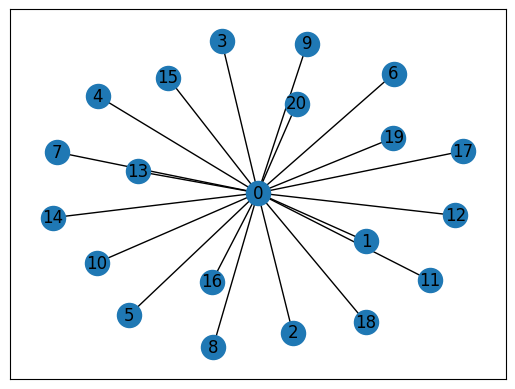

In [ ]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
